In [41]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sp
from scipy import signal
from lea_utils import APRBS,plot_states_double, norm_values
from lea_utils import MLEA
#%matplotlib tk

Definindo as variáveis simbólicas

0


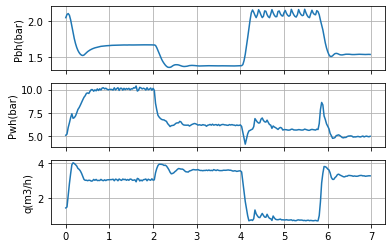

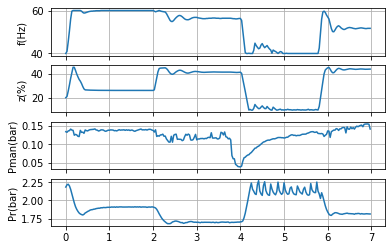

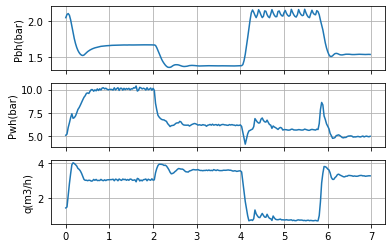

In [42]:
# =========================================================================
#  Define as entradas do BCS LEA   
# =========================================================================
# Instancia um objeto BCS LEA com dados experimentais
intervalo_horas=(0,7)
filepath="./dados_experimentais/Dados_BCSLEA_20210818.mat"
BCS_LEA=MLEA(filepath,intervalo_horas)
fk,zc,pman,pres=BCS_LEA.get_exo_values()
pbh,pwh,q=BCS_LEA.get_ss_values()
u_0=np.array([fk[0],zc[0],pman[0],pres[0]]) #Valor inicial de entrada
u_exp=np.array([fk,zc,pman,pres])#entradas exógenas experimentais
x_0=np.array([pbh[0],pwh[0],q[0]])#Valor inicial para os estados
xss=x_0;uss=u_0 #Iniciar a simulação
#####################################################
nsim=BCS_LEA.nsim
ts=BCS_LEA.ts
tempo_hora = np.arange(0,nsim*ts,ts)/3600
# ex_states=plot_states(tempo_hora,[pbh,pwh,q])
# BCS_LEA.plot_exogenous()
# BCS_LEA.plot_states()

In [43]:
####################
#Obter os fatores de escalonamento para simulação
xc,x0=norm_values()
####################
xssn = (xss-x0)/xc
#### Transformação para unidades de engenharia (bar, m3/h)
xscale=np.array([1/1e5,1/1e5,3600])
####
print(f"X estacionário_norm = {xssn}")
print(f"X estacionário = {np.array(xss)*xscale}")
print(f"X_0 = {x_0}")
(x_0-x0)/xc
np.array(xss)

X estacionário_norm = [0.69708344 0.3439367  0.27783165]
X estacionário = [2.04562516 5.09543031 1.46137507]
X_0 = [2.0456252e+05 5.0954303e+05 4.0593752e-04]


array([2.0456252e+05, 5.0954303e+05, 4.0593752e-04], dtype=float32)

SyntaxError: invalid syntax (<ipython-input-44-cf463a5954f9>, line 1)

In [ ]:
# Criando simbolica
from casadi import MX,Function
from casadi import vertcat as csvertcat
from casadi import sum1,nlpsol,integrator
nx = 3; nu = 4;
x = MX.sym("x",nx); # Estados normalizados
u = MX.sym("u",nu); # Entradas Exogenas
dudt_max = MX.sym("dudt_max",2); # Taxa das entradas exogenas
# from lea_utils import mod
from lea_utils import model as ED

dfq_max = 0.5;    # m�xima varia��o em f/s
dzc_max = 1;      # máxima variação em zc
dx1,dx2,dx3,pin,H=ED.EDO(x,u)


num=[1,2,3]
len(num)//2

In [ ]:
dxdt = csvertcat(dx1,dx2,dx3) 
# dxdt = casadi.vertcat(dpbhdt,dpwhdt,dqdt) 
Eq_Estado = Function('Eq_Estado',[x,u],[dxdt],
                     ['x','u'],['dxdt'])

In [ ]:
y=csvertcat(pin,H);
ny = y.size1()
# Equações algébricas
sea_nl = Function('sea_nl',[x,u],[y,pin,H],\
                 ['x','u'],['y','pin','H']); # Sistema de Eq. Algebricas variaveis de sa�da

BCS={
     'x': x,
     'u': u,
     'y': y,
     'nx': nx,
     'nu': nu,
     'ny': ny,
     'NaoLinear': {'sedo_nl': Eq_Estado(x,u),
                   'sea_nl': sea_nl
                   }
}
#%% Calculo do estacionario
#% Func��o objetivo
dxdt_0 = Eq_Estado(BCS['x'], BCS['u']);
J = sum1(dxdt_0**2);
#% Otimizador
opt={
     'ipopt':{
         'print_level':0,
         'acceptable_tol':1e-8,
         'acceptable_obj_change_tol':1e-6,
         'max_iter':150
         },
     'print_time':0,
     }

opt['ipopt']['print_level']=0;# %0,3
opt['print_time']=0;
opt['ipopt']['acceptable_tol']=1e-8;
opt['ipopt']['acceptable_obj_change_tol']=1e-6;
opt['ipopt']['max_iter']=50;


In [ ]:
sea_nl(xss,u_0)


(DM([3.06844e+10, 79.4624]), DM(3.06844e+10), DM(79.4624))

In [ ]:
Eq_Estado(np.array([0.559732, 0.540716, 0.652457]),
 np.array([5.6e1, 3.6e1, 1.4091657e+04, 2.1481252e+05]))
 #DM([-2.81127, 0.00946396, 1.64865e-05])

DM([-2.81127, 0.00946396, 1.64865e-05])

In [ ]:
#Encontrar o x que minimize J, dado u
MMQ = {'x':BCS['x'], 'f':J, 'p':BCS['u']} # variáveis, função custo, entradas
solver = nlpsol('solver', 'ipopt', MMQ, opt)
# Restrições das variaveis de decis�o
# minimo
args={
      'lbx': np.zeros((nx,1)),
# m�ximo
      'ubx':np.full((nx, 1), np.inf)
      }

# Solução do otimizador
sol=solver(x0=BCS['x'], lbx=args['lbx'], ubx=args['ubx'], p=BCS['u']);
yss=sea_nl(sol['x'],BCS['u'])
Estacionario = Function('Estacionario',[BCS['x'],BCS['u']],[sol['x']],['x0','uss'],['xss']);


In [ ]:
BCS['Estacionario'] = Estacionario;
xss=x_0;uss=u_0
print(xss)
print(uss)
Estacionario(xssn,uss)*xc+x0


[2.0456252e+05 5.0954303e+05 4.0593752e-04]
[4.0000000e+01 2.0000000e+01 1.3393538e+04 2.1787500e+05]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



DM([201964, 493374, 0.000429608])

In [ ]:
# Definir variaveis manipuladas e controladas e disturbio externo
mv = [0,1]    #% [f, Zc]
pv = [0,1]  #% [pin, H]  #% [P, I]
#pv = [2,3];  #% [pin, H]
de = 2;      #% [pm]
tg = 2;      #% MV target
#% Parametros
sedo = {'x': BCS['x'], # Estados
        'p': BCS['u'], #Variáveis exogenas
        'ode': Eq_Estado(x,u) # SEDO (Gerado no bcs_settings)
        };

#% Criando o objeto p,ra integração da Eq_estado
opt = {'tf':ts,
       't0':0
       };   #% opções do integrador

In [ ]:
int_odes = integrator('int_odes','cvodes',sedo,opt);
# objeto integrador
res = int_odes(x0=BCS['x'],p=BCS['u']);             #   % solução um passo a frente
npv = len(pv); nmv = len(mv);


In [ ]:
# Criando o objeto para solução da equação de medição
Eq_medicao = Function('Eq_medicao',[BCS['x'],BCS['u']],[BCS['y'][pv]],['x','u'],['y']);
# Criacao do objeto para simulacao do BCS Eq de estado + Eq de Medicao
Modelo_Predicao = Function('Modelo_Predicao',[BCS['x'],BCS['u']],[res['xf']],['xk_1','uk_1'],['xk']);


In [ ]:
def degrau(valor,time_step,time_vector):
    v=np.zeros_like(time_vector)
    for i in np.arange(0,len(time_vector)):
        if time_vector[i]<time_step:
            v[i]=valor[0]
        else:
            v[i]=valor[1]

    return v


time = np.arange(0.5, 1.8*3600, ts)
zc2=degrau([25,42],1.5*3600,time)# exogenous input
pm2=degrau([0.12,0.12],1*3600,time)*1e5# exogenous input
f2=degrau([60,56.5],0.8*3600,time)# exogenous input
pr2=degrau([1.9,1.7],1.1*3600,time)*1e5# exogenous input
2.5*3600/ts


# tempo_hora=time
time.shape
ts

#plot_exogenous(time,[f2,zc2,pm2,pr2])

100

In [ ]:
# nsim=36

nstep = nsim
nsim=u_exp.shape[1]

a_range = [35,65]
b_range = [30,50] # periodo de retenção em cada amplitude

u_f,prbs=APRBS(a_range,b_range,nstep)
u_z,prbs=APRBS(a_range,b_range,nstep)
uk_1 = np.array([np.ones_like(u_z)*40,u_z]);
#uk_1 = np.array([frequencia,val_pneumatica,pman,pres]);
prfixo=1.8e5; pr2=np.ones_like(f2)*prfixo
pmfixo=0.12e5;pm2=np.ones_like(f2)*pmfixo
zfixo=35;zc2=np.ones_like(f2)*zfixo


#uk_1 = np.array([f2,zc2,pm2,pr2]);
# uk_1=u_exp;uss=u_0
uss=uss.reshape([4,1])

#uk_1 = np.array([frequencia,val_pneumatica,np.ones_like(frequencia)*0.12*1e5,np.ones_like(frequencia)*1.9*1e5]);
#uk_1 = np.array([u_f,u_z,np.ones_like(frequencia)*0.12*1e5,np.ones_like(frequencia)*1.9*1e5]);
#uk_1 = np.array([np.ones_like(frequencia)*30,np.ones_like(frequencia)*30,np.ones_like(frequencia)*0.12*1e5,np.ones_like(frequencia)*1.9*1e5]);
# uk_1 = np.array([u_f,u_z]);
#Uss e xss simples
uk_1=np.array([fk,zc,pman,pres])
#uss=np.array([30,30,0.12*1e5,1.9*1e5]);
xss=Estacionario(xssn,uss)
xss
print(xss)
xss=Estacionario(xss,uss)
print(xss)


[0.679757, 0.325971, 0.295222]
[0.679757, 0.325971, 0.295222]


In [ ]:
uk_1[:,0:2]

array([[4.0000000e+01, 4.1000000e+01],
       [2.0000000e+01, 2.1000000e+01],
       [1.3393538e+04, 1.3238400e+04],
       [2.1787500e+05, 2.2093752e+05]], dtype=float32)

In [ ]:
x_0,xss

(array([2.0456252e+05, 5.0954303e+05, 4.0593752e-04], dtype=float32),
 DM([0.679757, 0.325971, 0.295222]))

### Simulação

In [ ]:
def compute_Pin_H(x,u):
    pbh,q,fq=x[0],x[2],u[0]

    #compute Pin and H after scaling
    g   = 9.81; 
    h1 =  9.3; 
    rho = 836.8898;pi=3.141592653589793  
    mu  = 0.012;r1=0.11;
    Re =(4*rho*q)/(0.219*pi*mu); # Assuming volumes density are identicals
    fric=64/Re
    F1 = (fric*q**2*rho)/(2*pi*r1**3)
    pin = pbh - rho * g * h1 - F1;
    #=============================================
    # Computing HEAD and pump pressure gain of LEA
      # Viscosity [Pa*s]
    H_aguabep = 4.330800000000000e+02; #ft
    Q_aguabep = 4.401900000000000e+02; #bpd
    y1 = -112.1374+6.6504*math.log(H_aguabep)+12.8429*math.log(Q_aguabep);
    Q = math.exp((39.5276+26.5605*math.log(mu*1000)-y1)/51.6565); #Pa.s to Cp;
    Cq = (1.0-4.0327e-3*Q-1.7240e-4*Q**2);
    CH = 1.0-4.4723e-03*Q -4.1800e-05*Q**2; # 80%
    f0=60 
    q0 = q / Cq * (f0 / fq)
    Head = np.array([78255575038455.9,-243021891442.447,154711075.976357,-63654.8760768729,187.303058039876]).T
    H0 =  Head[0]*q0**4 +  Head[1]*q0**3 +  Head[2]*q0**2 + Head[3]*q0 + Head[4];
    H = CH * H0 * (fq / f0) ** 2  # Head
    return pin,H

compute_Pin_H(xss,uss),ED.EDO(xssn,uss)[-2:],ED.EDO(xss,uss)[-2:]
Eq_medicao(xssn,uss),compute_Pin_H(xss,uss),ED.EDO(xssn,uss)[-2:],ED.EDO(xss,uss)[-2:]

(DM([128211, 68.8334]),
 (DM(-76356), DM(1.4852e+12)),
 (128210.54296828608, array([68.83339], dtype=float32)),
 (DM(125612), DM(67.4951)))

In [ ]:
H

MX(@1=u[0], @2=(((2.77778e-05+(0.00136111*x[2]))/0.964528)*(60/@1)), (-11.4925+(215.923*((((0.967594*(187.303+((((7.82556e+13*pow(@2,4))+(-2.43022e+11*pow(@2,3)))+(1.54711e+08*sq(@2)))+(-63654.9*@2))))*sq((@1/60)))--11.4925)/215.923))))

In [ ]:
Modelo_Predicao(xss,uss)

DM([0.679757, 0.325971, 0.295222])

In [ ]:
print("Simulação iniciada")
xss=Estacionario(x_0,uss)
xpk = Modelo_Predicao(xss,uss) #valores normalizados
xpks=xpk*xc+x0
k=0
pin,H=compute_Pin_H(xpks,uk_1[:,k:k+1])
Yk=np.array([[pin],[H]])
print(Yk.shape)
#Inicialização do vetor de estados
Xk=xpk*xc+x0
#Inicialização do vetor de entradas exogenas
Uk= uss
xi=tempo_hora
for k in range(1,nsim):
    xpk = Modelo_Predicao(xpk,uk_1[:,k:k+1])
    xpks=xpk*xc+x0
    pin,H=compute_Pin_H(xpks,uk_1[:,k:k+1])
    Yk=np.concatenate([Yk,np.array([[pin],[H]])],axis=1)
    #print(xpk,uk_1[:,k:k+1].T)
    #print(uk_1[:,k:k+1])
    Xk = np.concatenate([Xk,xpks],axis=1) #desnormalizar x e preencher vetor
    Uk = np.concatenate([Uk,uk_1[:,k:k+1]],axis=1)
print("Ok.simulação concluida")


Simulação iniciada
(2, 1)
Ok.simulação concluida


In [ ]:
def plot_y_double(tempo,var,var_exp):
    label = ['Pin(bar)',"H(m)"];
    fig3=plt.figure()
    for i,(var,var_exp) in enumerate(zip(var,var_exp)):
        ax1=fig3.add_subplot(len(label),1,i+1)
        ax1.plot(tempo ,var,'-b',label="sim")
        ax1.plot(tempo ,var_exp, ':r', label="exp")
        ax1.set_ylabel(label[i])
        if i+1!=len(label):
            ax1.set_xticklabels([])
        plt.grid(True)
    ax1.set_xlabel("Time(h)")
    plt.legend(bbox_to_anchor=(1.0, -0.3), ncol = 2)
    return fig3
#plot_y_double(tempo_hora,[Yk[0,:]/1e5,Yk[1,:]],[LEA['pressao_intake'],LEA['nivel_intake']])

### Resultados

1e-05
1e-05
3600


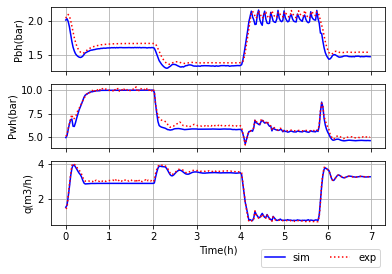

In [ ]:
sim_states=[Xk[0,:],Xk[1,:],Xk[2,:]]
exp_states=[pbh,pwh,q]
# estados simulados vs experimentais
plot_ss=plot_states_double(tempo_hora,sim_states,exp_states)


In [ ]:
print('teste')

teste


<ipython-input-31-a3f713936d6c>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


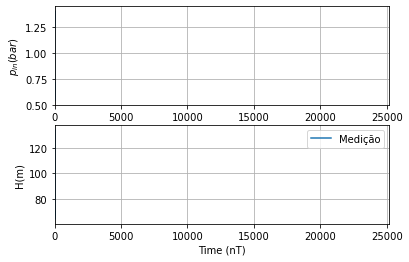

In [ ]:
fig1=plt.figure()
label = [r'$p_{in}(bar)$','H(m)','P','I','qc','qr' ];
for iy in range(0,npv):
    ax = fig1.add_subplot(npv,1,iy+1)
    #print(iy)
    if iy == 0: # Pin
        ax.plot(xi,(Yk[iy,:].T)/1e5, label='Medição')
        #ax.plot(xi,Ymk[iy,:].T/1e5, label='EKF')
        ax.set_ylabel(label[iy])
        ax.set(xlim=(xi[0], nsim*ts))
       # ax.set(ylim=(40,62))
        plt.grid(True)
    else: # H
        ax.plot(xi,Yk[iy,:].T, label='Medição')
        #ax.plot(xi,Ymk[iy,:].T,label='EKF')
        ax.set_ylabel(label[iy])
        ax.set(xlim=(xi[0], nsim*ts))
       # ax.set(ylim=(580, 850))
        plt.grid(True)
#ax.plot(xi,Yk[2,:].T, label='EKF')
ax.legend();
ax.set_xlabel('Time (nT)')
fig1.show()


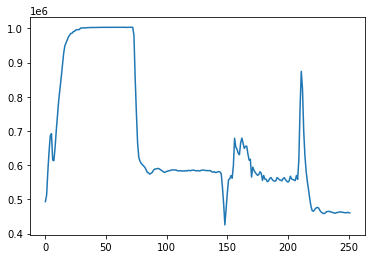

In [ ]:
plt.plot(Xk[1,:])

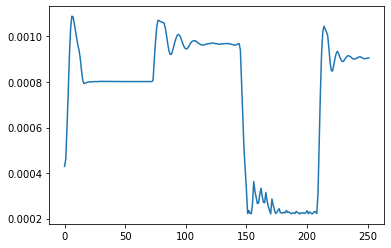

In [ ]:
plt.plot(Xk[2,:])

In [ ]:
# #exec(compile(open('envelope.py', "rb").read(), 'envelope.py', 'exec')) #% Roda arquivo com parâmetros do modelo BCS
# fig4,ax4=plt.subplots()
# plt.grid(True)
# #BCS['Envelope']['fig'](ax4); # grafico do envelope
# #
# # Evolução dentro do envelope
# ax4.plot(Xk[2,0:].T*3600,Yk[1,0:].T,'--k')
# ax4.plot(Xk[2,0]*3600,Yk[1,0],'o')#,'MarkerFaceColor',[0,1,0],'MarkerEdgeColor',[0,0,0])
# ax4.plot(Xk[2,-1]*3600,Yk[1,-1],'o')#,'MarkerFaceColor',[1,0,0],'MarkerEdgeColor',[0,0,0])
# ax4.annotate('t=0',
#              xy=(float(Xk[2,0]*3600),float(Yk[1,0])),
#              xytext=(float(Xk[2,0]*3600)-5,float(Yk[1,0])+10),
#              arrowprops=dict(facecolor='green', shrink=0.01))

# ax4.annotate('t='+str(nsim),
#              xy=(float(Xk[2,-1]*3600),float(Yk[1,-1])),
#              xytext=(float(Xk[2,-1]*3600)-7,float(Yk[1,-1])+10),
#              arrowprops=dict(facecolor='red', shrink=0.01))
# plt.show()



In [ ]:
#np.savez('LEA_data_train-f.npz', t=xi, x1=Xk[0,:].T,x2=Xk[1,:].T,x3=Xk[2,:].T,zc=zc2,f=f2,pm=pm2,pr=pr2)

In [ ]:
def ler_dados(str):
    with open(str, 'r') as f:
        d = f.readlines()
        epocas = np.zeros(len(d));
        tau = np.zeros(len(d));
        j = 0;
        data = []
        for i in d:
            k = i.rstrip().split(" ")
            data.append([float(i) if is_float(i) else i for i in k])
            epocas[j] = float(k[0])
            tau[j] = float(k[1])
            j += 1;
    
    return tau, epocas


In [ ]:
qcc/qc

NameError: name 'qcc' is not defined